# The Grover Search Algorithm

## MITP 2023

Grover's algorithm is one of the most famous quantum algorithms [1], and was initially designed as a search algorithm for unstructured datasets, achieving a quadratic speedup over classical approaches. A generalised version of the Grover algorithm, Amplitude Amplification and Estimation [2], has since been used as a subroutine in many quantum algorithms.  

Database search algorithms can be applied to a broad range problems in High Energy Physics, and therefore the Grover algorithm is of great interest to the QCHEP community. Here we will show a simple example of the Grover algorithm: searching for a marked element in an unstructed datase. In this notebook, we will use Qiskit. If you get stuck, see the Introduction to Quantum Computing notebook.

In [1]:
import warnings

# Ignore all DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
from qiskit import (QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute)
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import *
sim = Aer.get_backend('qasm_simulator')

## Database search

The aim of the Grover search algorithm is to find one or more *marked* elements in an unstructured database. To do this, we define an oracle $f(x)$ which returns identify if $x=\omega$ and zero otherwise. 

Classically, one can only find the marked elements by the *brute force* method, requiring $\mathcal{O}(N)$ calls of the oracle for a dataset of $N$ elements with one marked element. The Grover algorithm is an optimial quantum algorithm which can achieve a polynomial speedup, requiring $\mathcal{O}(\sqrt{N})$ queries of the oracle to successfully identify the marked state. 

In the quantum regime, the oracle is a unitary operation $U_f$ which, when applied to the computational basis, acts on the system as

$$
U_f : \vert x \rangle \otimes \vert q \rangle \rightarrow \vert x \rangle \otimes \vert q \oplus f(x) \rangle,
$$

where $\vert x \rangle$ is the input register and $\vert q \rangle$ is the oracle qubit, which is flipped if and only if $f(x)=1$. Consequently, we can check if $x$ is the marked element by initialising the system in the $\vert x \rangle \vert 0 \rangle$ state and measuring $\vert q \rangle$ at the end of the algorithm. If $\vert q \rangle$ is in the 1 state, then $x$ is the marked element. 

### Exercise: 

Try coding up an example of this approach by filling in the blanks below. Search a database of 8 elements, encoded on a 3 qubit basis. Does it achieve a speedup?

Gover's Algorithm from IBM quantum learning tutorials 

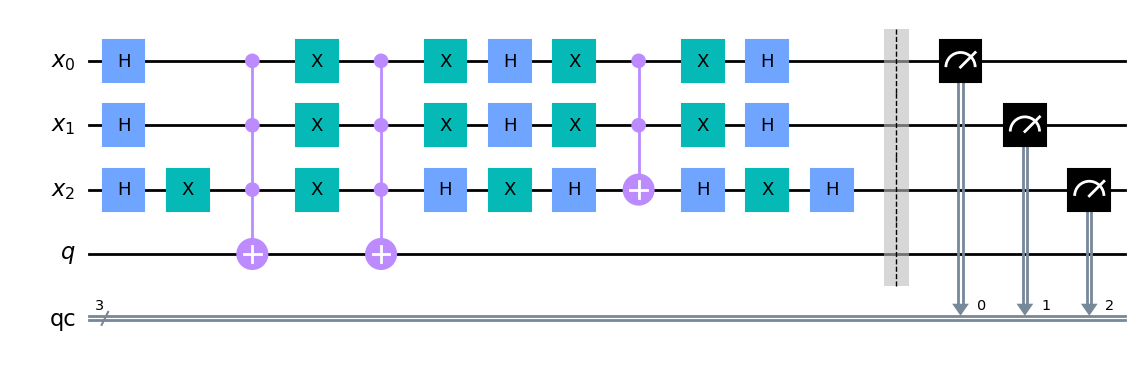

In [8]:
x    = QuantumRegister(3, name='x')
q    = QuantumRegister(1,name='q')
qc   = ClassicalRegister(3, name='qc')
circuit = QuantumCircuit(x,q,qc)


circuit.h(x) #initializing |0>
#circuit.barrier()

circuit.x(x[-1])
circuit.mct(x, q)
circuit.x(x)
circuit.mct(x, q)
circuit.h(x[-1])
circuit.x(x)
circuit.h(x)
circuit.x(x[0:2])
circuit.mct(x[:-1],x[-1])
circuit.h(x[-1])
circuit.x(x)
circuit.h(x)
circuit.barrier()

#circuit.h(q)
circuit.measure(x, qc)
#circuit.measure(q,qc)
circuit.draw('mpl')

Job Status: job has successfully run


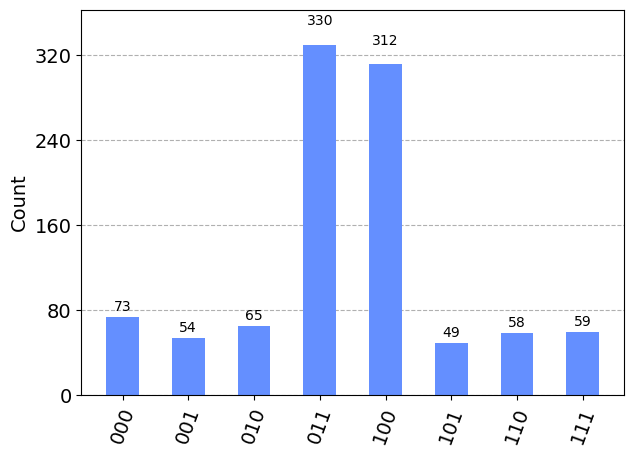

In [4]:
job = execute(circuit, sim, shots=1000)
job_monitor(job)
counts = job.result().get_counts()
plot_histogram(counts)

code from AA below

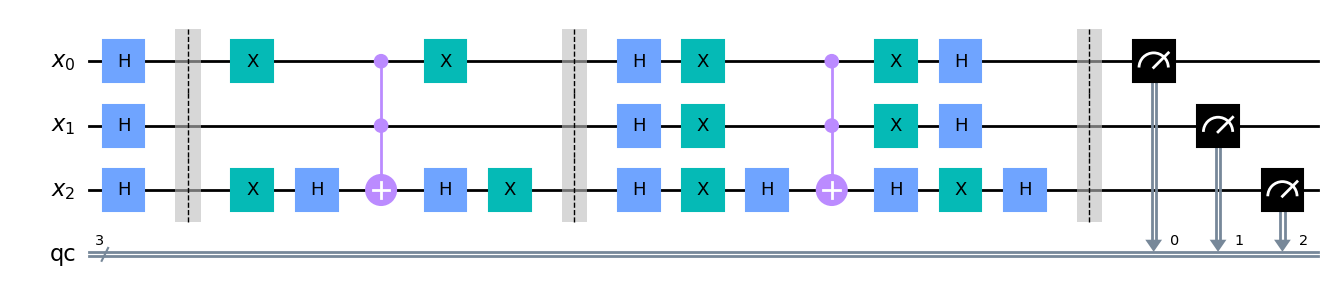

In [7]:
x    = QuantumRegister(3, name='x')
#q    = QuantumRegister(1,name='q')
qc   = ClassicalRegister(3, name='qc')
circuit = QuantumCircuit(x,qc)
    
marked_state=[0,1,0]
circuit.h(x) #A operation
circuit.barrier()
#oracle

for i in range(len(marked_state)):
    if marked_state[i] == 0:
       circuit.x(x[i])
circuit.h(x[-1])
circuit.mct(x[:-1],x[-1])
circuit.h(x[-1])
for i in range(len(marked_state)):
    if marked_state[i] == 0:
       circuit.x(x[i])
        
circuit.barrier()


### Diffuser
circuit.h(x) #A dgr
circuit.x(x) #S
circuit.h(x[-1])
circuit.mct(x[:-1],x[-1])
circuit.h(x[-1])
circuit.x(x)
circuit.h(x) #A
circuit.barrier()

#circuit.h(q)
circuit.measure(x, qc)
#circuit.measure(q,qc)
circuit.draw('mpl')

Job Status: job has successfully run


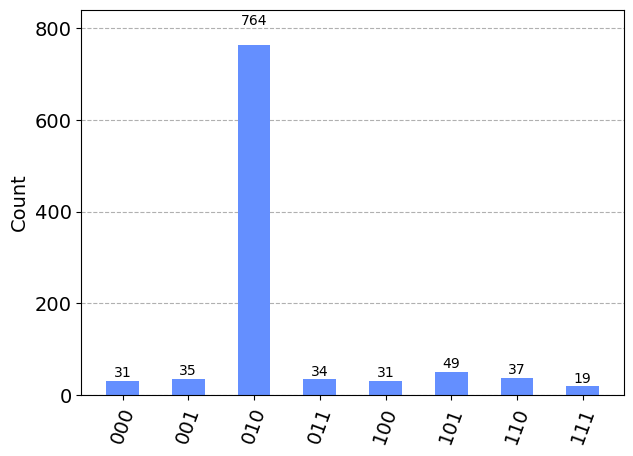

In [8]:
job = execute(circuit, sim, shots=1000)
job_monitor(job)
counts = job.result().get_counts()
plot_histogram(counts)

Hints: 

- You need to initilise your $x$ register. What is the optimal way of doing this? How to best utilise the properties of the quantum device. 
- You then need to construct an oracle which will update $\vert q \rangle$ only when x = w. 

If you struggle, below there is an example of the Amplitude Amplification approach to the Grover algorithm. 

### Achieving the speedup

The above method has yet to unlock the speedup as one would need to go one by one and encode each element in the data base and perform the orcale transformation, again requiring $\mathcal{O}(N)$ queries of the oracle. 

To unlock the speedup, we need to move to the quantum paradigm and make use of superposition states. Here we initialise the oracle qubit $\vert q \rangle$ in the $\vert - \rangle = (\vert 0 \rangle -\vert 1\rangle)/\sqrt{2}$ state, such that the action of the oracle is now

$$
U_f : \vert x \rangle \Bigg[ \frac{1}{\sqrt{2}} \big( \vert 0 \rangle - \vert 1 \rangle \big) \Bigg] \rightarrow (-1)^{f(x)} \vert x \rangle \Bigg[ \frac{1}{\sqrt{2}} \big( \vert 0 \rangle - \vert 1 \rangle \big) \Bigg].
$$

Therefore, if $x=w$ then a negative phase is applied to the whole system, leaving the $\vert - \rangle$ state unchanged. Thus, for simplicity, we can omit the oracle qubit and define the oracle operation as 

$$
U_f : \vert x \rangle \rightarrow (-1)^{f(x)} \vert x \rangle.
$$

Thus the oracle *marks* the solution to our search problem with a negative phase. 

### Circuit build

Below we build the circuit for a simple search of a database of 8 elements. We have identified that the state we are looking for is the $\vert 010 \rangle$. 

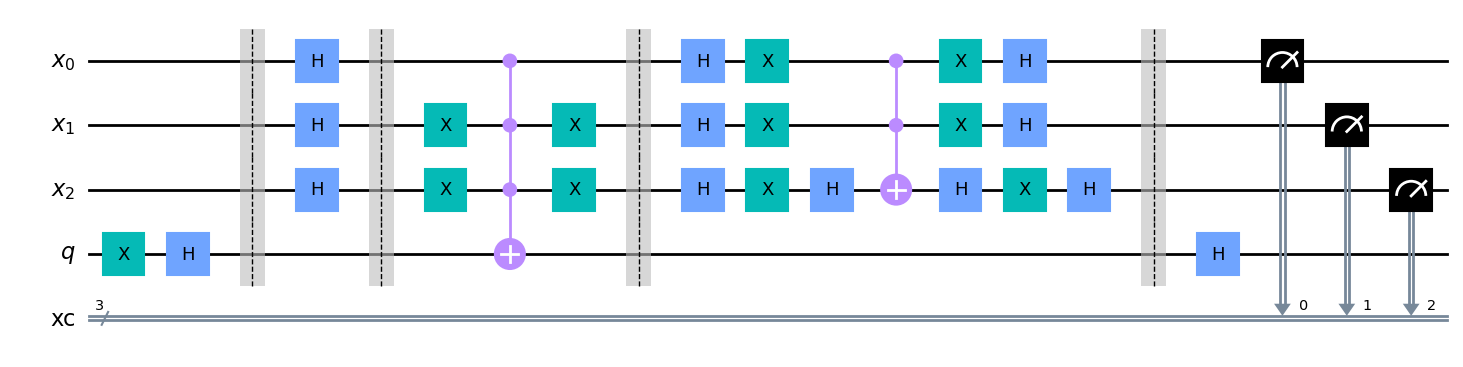

In [7]:
good_state = [1,0,0] #0,1,0

x  = QuantumRegister(3, name='x')
xc = ClassicalRegister(3, name='xc')
q  = QuantumRegister(1, name='q')

circuit = QuantumCircuit(x, q, xc)

### Initialise the system in |0>|->
circuit.x(q)
circuit.h(q)
circuit.barrier()

### Basis encoding of the database
circuit.h(x)
circuit.barrier()

### Oracle: build oracle for finding the good_state
for i in range(len(good_state)):
    if good_state[i] == 0:
        circuit.x(x[i])
circuit.mct(x, q)
for i in range(len(good_state)):
    if good_state[i] == 0:
        circuit.x(x[i])
circuit.barrier()

### Diffuser
circuit.h(x)
circuit.x(x)
circuit.h(x[-1])
circuit.mct(x[:-1],x[-1])
circuit.h(x[-1])
circuit.x(x)
circuit.h(x)
circuit.barrier()

circuit.h(q)
circuit.measure(x, xc)
circuit.draw('mpl')

Here we have split the circuit up into slices separated by barriers:

1. We set up our problem by initialising the system as 

$$
\vert \psi\rangle = \vert x \rangle \vert q \rangle = \vert 000 \rangle \vert - \rangle.
$$

2. We then need to embed the database onto the quantum device. Here we use basis embedding and encode the state as 8 binary bit strings. We can embed the database using a series of Hadamard gates applied to all qubits in the $x$ register, putting the register into a linear superposition of all possible basis states. 

3. The next step is to build the oracle that will find our marked state. We flip the $q$ qubit if and only if the orcale controls from our `good_state`, exploiting [phase kickback](https://medium.com/quantum-untangled/a-clever-quantum-trick-54f27e2518a4) to mark the state.

4. Now that we have marked the state with a negative phase, we need to *rotate* the initial state towards the target state, i.e. perfrom a rotation on all states such that the target state is amplified. We do this by applying an operation of the form $\vert \psi \rangle \langle \psi \vert - \mathbb{I}$. This step is often called diffusion. See [here](https://quantum-computing.ibm.com/composer/docs/iqx/guide/grovers-algorithm) for a detailed discussion of the geometric approach to Grover's algorithm. 

5. Finally we measure the $x$ register. 

We now run the algorithm on the quantum simulator

Job Status: job has successfully run


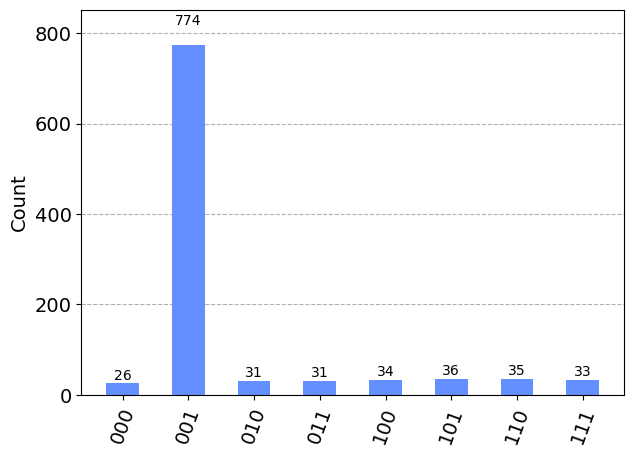

In [8]:
job = execute(circuit, sim, shots=1000)
job_monitor(job)
counts = job.result().get_counts()
plot_histogram(counts)

We see that the target state has been amplified such that we can identify the state with close to certainty. 

## Excercise: picking your oracle

We have seen above that the oracle allows us to amplify the $\vert 010 \rangle$ state using the oracle

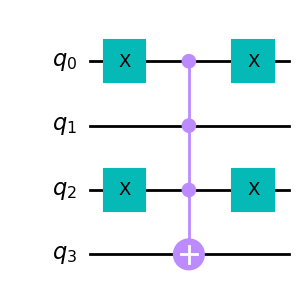

In [9]:
oracle = QuantumCircuit(4)

oracle.x(0)
oracle.x(2)
oracle.mct([0,1,2], 3)
oracle.x(0)
oracle.x(2)
oracle.draw('mpl')

The construction of the oracle is the most important part of the search algorithm, and of many quantum algorithms. Can you construct an oracle which will find other states in our 8 basis states? How does the oracle really mark the state?

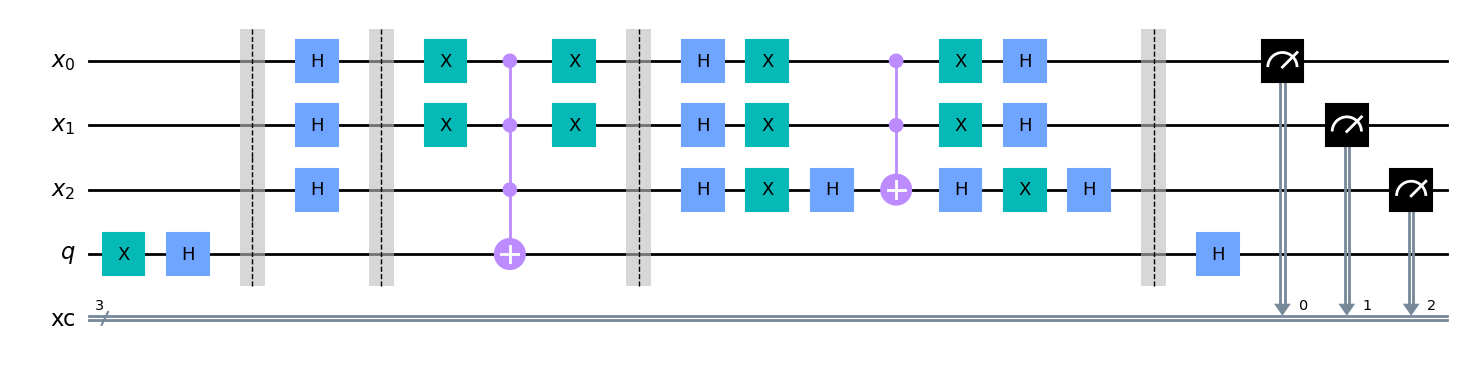

In [14]:
orc_circ = QuantumCircuit(x, q, xc)

### Initialise the system in |0>|->
orc_circ.x(q)
orc_circ.h(q)
orc_circ.barrier()

### Basis encoding of the database
orc_circ.h(x)
orc_circ.barrier()

### Oracle: build oracle for finding the good_state
"""orc_circ.x(x)
orc_circ.mct(x, q)
orc_circ.x(x)
orc_circ.barrier()"""
orc_circ.x(x[0])
orc_circ.x(x[1])
orc_circ.mct(x, q)
orc_circ.x(x[0])
orc_circ.x(x[1])
orc_circ.barrier()

### Diffuser
#A_G
orc_circ.h(x) 

#S_0 phase inversion on the zero state
orc_circ.x(x)
orc_circ.h(x[-1])
orc_circ.mct(x[:-1],x[-1])
orc_circ.h(x[-1])
orc_circ.x(x)

#A_G
orc_circ.h(x) 
orc_circ.barrier()

orc_circ.h(q)
orc_circ.measure(x, xc)
orc_circ.draw('mpl')

Job Status: job has successfully run


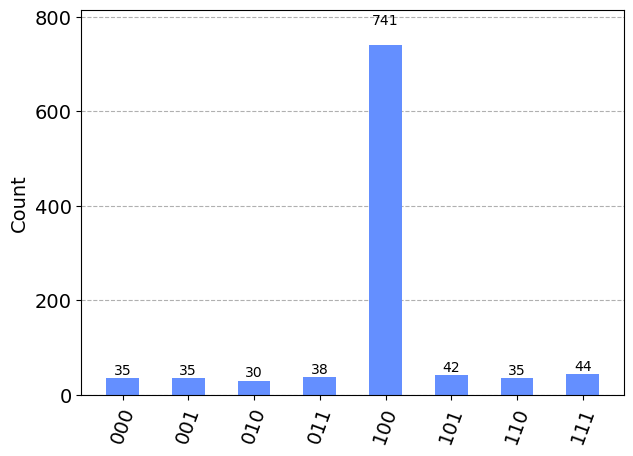

In [15]:
job = execute(orc_circ, sim, shots=1000)
job_monitor(job)
counts = job.result().get_counts()
plot_histogram(counts)

## Exercise: reducing qubit number

The above can be simplified even further by utilising more of the gate operations on offer to NISQ devices. Can you remove the need to have an oracle workspace and qubit? 

Hint: think about the effect that the oracle has on the state for the algorithm above. Can this be replaced?

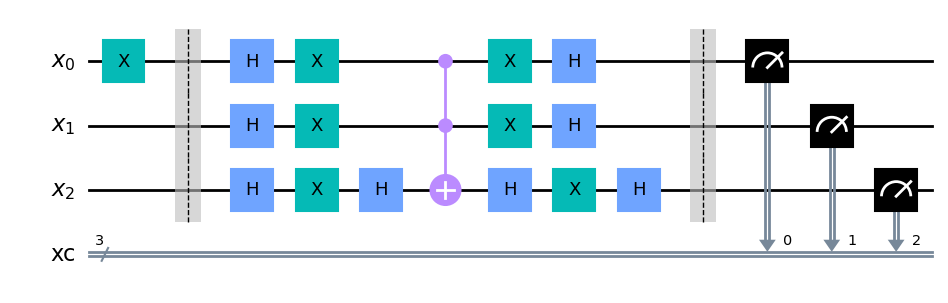

In [28]:
x        = QuantumRegister(3, name='x')
xc       = ClassicalRegister(3, name='xc')
circuit2 = QuantumCircuit(x, xc)

good_state=[1,0,0]
### Data embedding 


### Oracle
for i in range(len(good_state)):
    if good_state[i] == 1:
       circuit2.x(x[i])

circuit2.barrier()

### Diffuse
circuit2.h(x)
circuit2.x(x)
circuit2.h(x[-1])
circuit2.mct(x[:-1],x[-1])
circuit2.h(x[-1])
circuit2.x(x)
circuit2.h(x)
circuit2.barrier()

circuit2.measure(x, xc)
circuit2.draw('mpl')

Job Status: job has successfully run


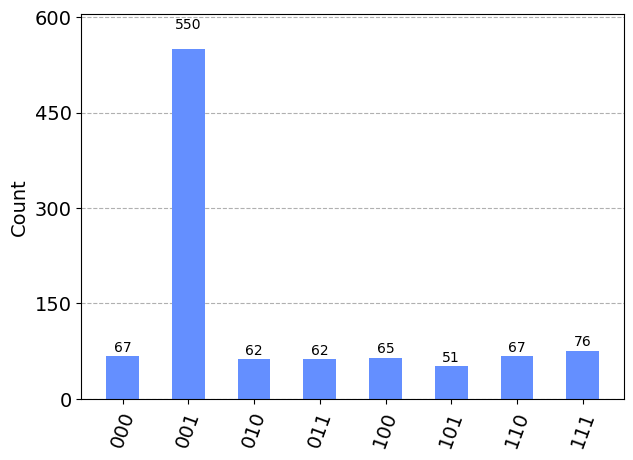

In [29]:
job = execute(circuit2, sim, shots=1000)
job_monitor(job)
counts = job.result().get_counts()
plot_histogram(counts)

## Exercise: larger databases

Try increasing the number of states that are in your database and running the algorithm (remember that you will have to adjust your oracle and encoding). What do you find? Do you find the target with certainty? How can we increase the likelihood of finding the target state?

working with 5 qubits, 32 states 

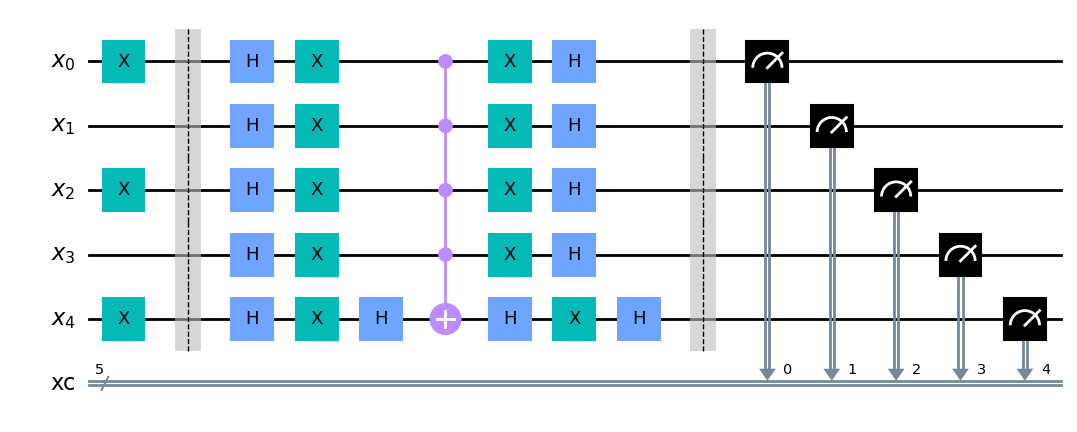

In [9]:
x        = QuantumRegister(5, name='x')
xc       = ClassicalRegister(5, name='xc')
big_circ = QuantumCircuit(x, xc)

good_state = [1,0,1,0,1] #0,1,0


### Oracle: build oracle for finding the good_state
for i in range(len(good_state)):
    if good_state[i] == 1:
        big_circ.x(x[i])

big_circ.barrier()
### Diffuser
big_circ.h(x)
big_circ.x(x)
big_circ.h(x[-1])
big_circ.mct(x[:-1],x[-1])
big_circ.h(x[-1])
big_circ.x(x)
big_circ.h(x)
big_circ.barrier()


big_circ.measure(x, xc)
big_circ.draw('mpl')

Job Status: job has successfully run


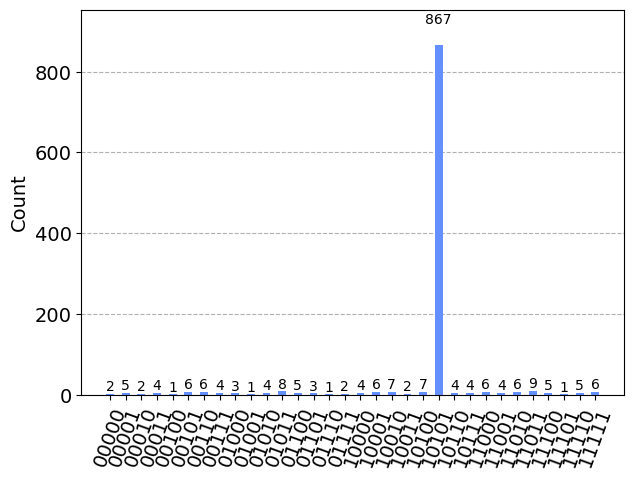

In [10]:
job = execute(big_circ, sim, shots=1000)
job_monitor(job)
counts = job.result().get_counts()
plot_histogram(counts)

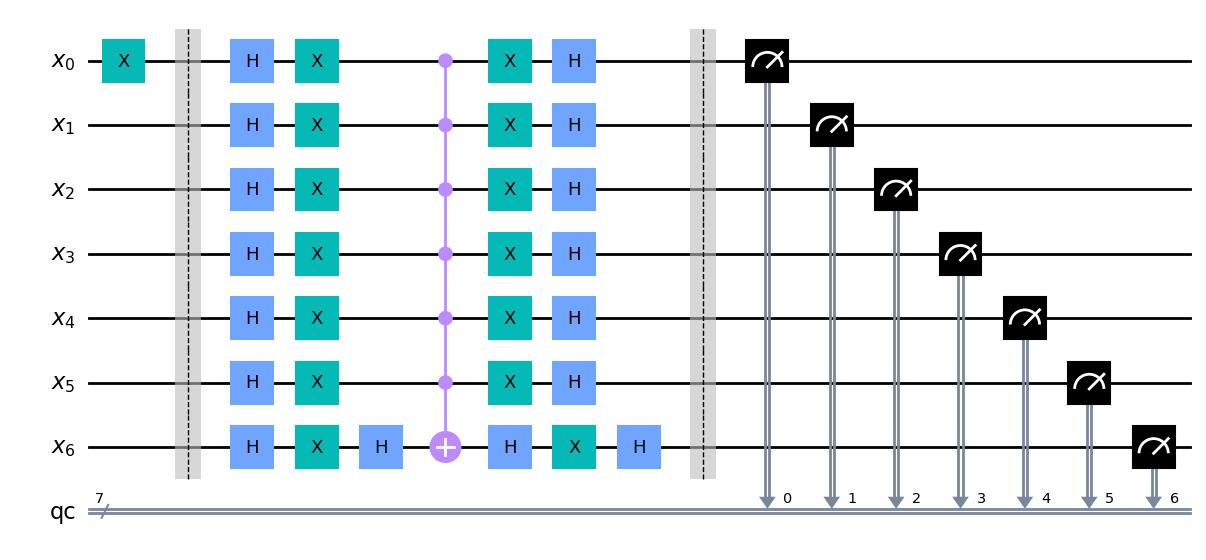

In [13]:
x    = QuantumRegister(7, name='x')
qc   = ClassicalRegister(7, name='qc')
circuit = QuantumCircuit(x,qc)
    
marked_state=[1,0,0,0,0,0,0]
for i in range(len(marked_state)):
    if marked_state[i] == 1:
       circuit.x(x[i])
circuit.barrier()


### Diffuser
circuit.h(x)
circuit.x(x)
circuit.h(x[-1])
circuit.mct(x[:-1],x[-1])
circuit.h(x[-1])
circuit.x(x)
circuit.h(x)
circuit.barrier()

#circuit.h(q)
circuit.measure(x, qc)
#circuit.measure(q,qc)
circuit.draw('mpl')

Job Status: job has successfully run


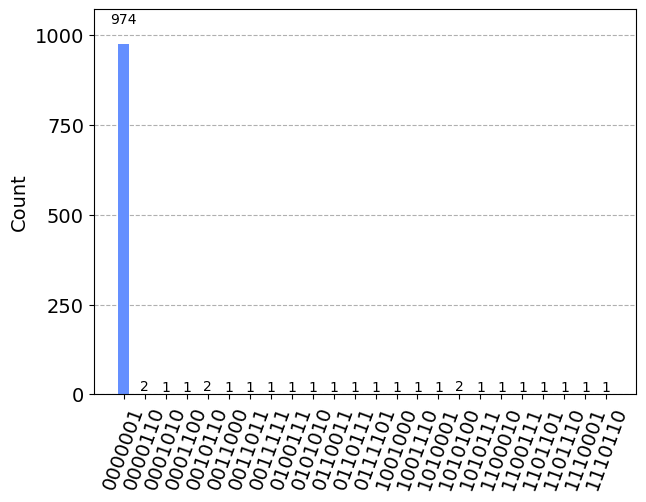

In [14]:
job = execute(circuit, sim, shots=1000)
job_monitor(job)
counts = job.result().get_counts()
plot_histogram(counts)

## Exercise: more than one target?

How would you write a search algorithm that is looking for more than one marked element? Knowing what you have learnt from the last exercise, what would you need to know before you run the algorithm. Bonus: is there a way you could get around knowing too much before you start running the algorithm? Can you let the quantum computer do it for you?

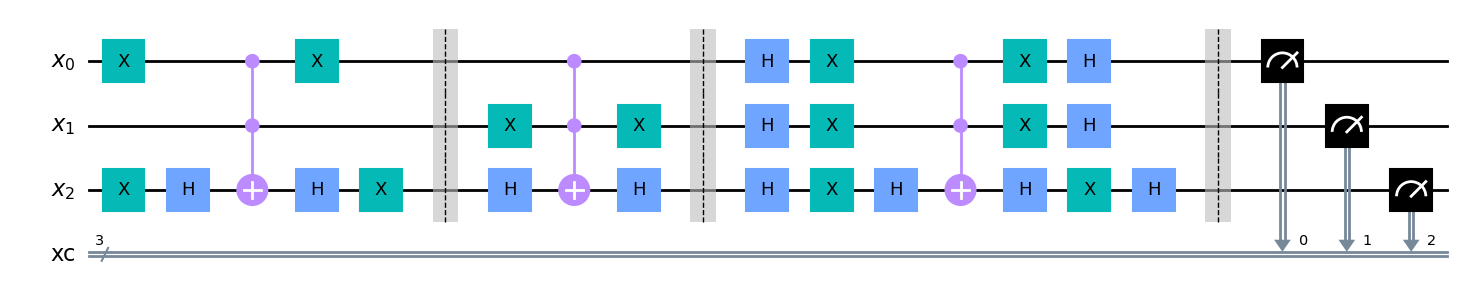

In [18]:

x        = QuantumRegister(3, name='x')
xc       = ClassicalRegister(3, name='xc')
circuit2 = QuantumCircuit(x, xc)

good_state=[[0,1,0],[1,0,1]]
### Data embedding 


### Oracle
for i in range(len(good_state)):
    for j in range(3):
        if good_state[i][j] == 0:
           circuit2.x(x[j])
    circuit2.h(x[-1])
    circuit2.mct(x[:-1], x[-1])
    circuit2.h(x[-1])
    for j in range(3):
        if good_state[i][j] == 0:
           circuit2.x(x[j])
    circuit2.barrier()

### Diffuse
circuit2.h(x)
circuit2.x(x)
circuit2.h(x[-1])
circuit2.mct(x[:-1],x[-1])
circuit2.h(x[-1])
circuit2.x(x)
circuit2.h(x)
circuit2.barrier()

circuit2.measure(x, xc)
circuit2.draw('mpl')

Job Status: job has successfully run


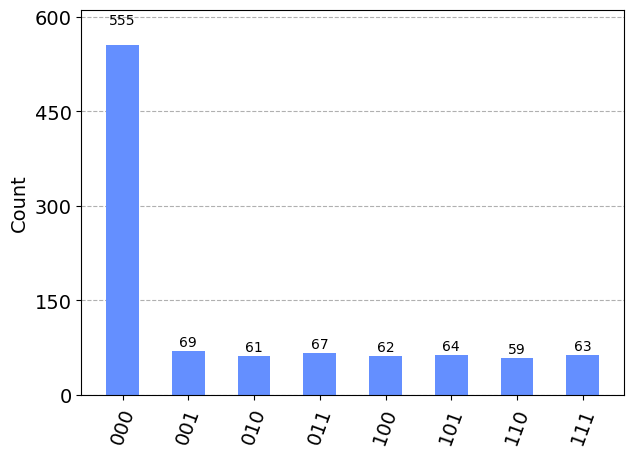

In [19]:
job = execute(circuit2, sim, shots=1000)
job_monitor(job)
counts = job.result().get_counts()
plot_histogram(counts)

## Exercise: another embedding?

Currently, we are using basis encoding, which is very simple and easy to use...but is it the most efficient or the best for your problem? Can you write a search algorithm that uses a different embedding? When would this be useful?

Hint: if you are struggling, check our Amplitude Estimation

In [ ]:
x        = QuantumRegister(n, name='x')
xc       = ClassicalRegister(n, name='xc')
enc_circ = QuantumCircuit(x, xc)

### your code here

[1] L. K. Grover, A fast quantum mechanical algorithm for database search. Proceedings 28th Annual Symposium on the Theory of Computing (STOC) 1996, pp. 212-219. [arXiv:quant-ph/9605043](https://arxiv.org/abs/quant-ph/9605043)

[2] Brassard, G., Hoyer, P., Mosca, M., & Tapp, A. (2000). Quantum Amplitude Amplification and Estimation. [arXiv:quant-ph/0005055](http://arxiv.org/abs/quant-ph/0005055)